# Red Wine Quality project

## Introduction

### Content
1. Notebook setup
2. Dataset preparation
    1. Data Cleaning
        - Duplicate entries
        - Missing values
        - Outliers
    2. General overview
        - Sample sizes
        - Feature distributions
        - Feature correlations
        - Feature relationship with quality
           - Mean distribution across quality levels
           - Value distributions across quality levels
3. Goals
4. Calculations
    1. Positive impact
        1. Independent variable: linear regression
        2. Check for linear regression assumptions
        3. Independent variable: Linear model performance on holdout data
        4. Independent variable: Logistic regression
        5. Logistic regression assumptions
        6. Summary of independent variable impact on quality
    2. Negative impact
        1. Independent variable: linear regression
        2. Check for linear regression assumptions
        3. Independent variable: Linear model performance on holdout data
        4. Independent variable: Logistic regression
        5. Logistic regression assumptions
        6. Summary of independent variable impact on quality
5. Conclusions of analysis
6. Suggestions for improvement



</br>

The dataset consists of the following features:</br>
**Input variables:**
1. fixed acidity - most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2. volatile acidity - the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3. citric acid - found in small quantities, citric acid can add 'freshness' and flavor to wines
4. residual sugar - the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5. chlorides - the amount of salt in the wine
6. free sulfur dioxide - the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7. total sulfur dioxide - amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8. density - the density of water is close to that of water depending on the percent alcohol and sugar content
9. pH - describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10. sulphates - a wine additive which can contribute to sulfur dioxide gas (S02) levels, which acts as an antimicrobial and antioxidant
11. alcohol - the percent alcohol content of the wine

**Output variable:**
1. quality (score between 0 and 10)

## 1. Notebook setup

In [145]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor as VIF,
)
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tukey_fences import tukey_fences_method
from handle_duplicates import handle_duplicates_method
from linear_reg_assumptions import check_linear_reg_assumptions
from logistic_reg_assumptions import check_logistic_reg_assumptions
from Test_holdout import test_holdout_model

In [146]:
color_palette = {
    "wine": "#80033A",
    "fixed acidity": "#D4352D",
    "volatile acidity": "#E55921",
    "citric acid": "#DDF748",
    "residual sugar": "#DDBA9A",
    "chlorides": "#37D693",
    "free sulfur dioxide": "#D6B43E",
    "total sulfur dioxide": "#C6D60D",
    "density": "#FA7274",
    "pH": "#B185E0",
    "sulphates": "#0AD6C9",
    "alcohol": "#D63069",
    "quality": "#B0B0B0",
}

wine_property_ranges = {
    "fixed acidity": [4.0, 15.0],
    "volatile acidity": [0.1, 1.5],
    "citric acid": [0.0, 1.0],
    "residual sugar": [0.9, 15.0],
    "chlorides": [0.01, 0.2],
    "free sulfur dioxide": [1.0, 72.0],
    "total sulfur dioxide": [6.0, 289.0],
    "density": [0.990, 1.004],
    "pH": [2.8, 4.0],
    "sulphates": [0.3, 2.0],
    "alcohol": [8.0, 14.9],
    "quality": [0, 10],
}

wine = pd.read_csv("winequality-red.csv")

In [147]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. Datset preparation

### A. Data cleaning

#### Duplicate entries
A total of 240 duplicated entries were found and deleted.

In [148]:
print(handle_duplicates_method(wine))
wine = wine.reset_index(drop=True)

Found and deleted 240 duplicate(s).


#### Missing data
Missing data will be checked the following ways:
1. If there are any missing values (NaN) in the dataset
2. If there are any features that have values of 0

As you can see below there are no missing values.</br>
There is one feature 'Citric Acid' which has values of 0 however since it can range from 0 to 500 mg/L it is acceptable.

In [149]:
print(
    f""" Are there missing values?
{wine.isnull().any()}\n
"""
)

null_features = []

for feature in wine.columns:
    if (wine[feature] == 0).any():
        null_features.append(feature)

if null_features != []:
    print(
        f"The following features values include  0:\n{', '.join(null_features)}"
    )
else:
    print("There are no features with values including 0.")

 Are there missing values?
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool


The following features values include  0:
citric acid


#### Outliers
The following table shows:
* **Property range**: The range of acceptable values for a given property
* **Number of outliers**: number of the outliers found by Tukey fence method
* **Percentage of data loss**: the percentage of data loss if those outliers are to be removed
* **Within property range**: if any of outliers are not within the ranges acceptable for the wine property the cell will have 'NO'
* **Outliers out of range**: the number of outliers found by Tuckey fence method that are as well out of property range
* **Data loss % of out of range outliers**: the percentage of data loss if those outliers are to be removed

**Note:** 
If no outliers are detected only property range and number of outliers will be shown.</br>
If outliers are found but they are within acceptable range the last 2 columns will be empty.</br>


**Only the outliers that are NOT within the property range will be removed.**

In [150]:
outlier_data = {}
out_to_drop = []
for feature in wine.columns:
    outliers, proc = tukey_fences_method(wine, feature)
    range_pass = "Yes"
    count_out_range = 0
    for out_val in outliers:
        if (
            wine.loc[out_val, feature] < wine_property_ranges[feature][0]
            or wine.loc[out_val, feature] > wine_property_ranges[feature][1]
        ):
            range_pass = "NO"
            count_out_range += 1
            out_to_drop.append(out_val)
    out_of_range_proc = f"{round(count_out_range*100/wine.shape[0],2)} %"
    len_out = len(outliers)
    if len_out == 0:
        range_pass = ""
        proc = ""
        count_out_range = ""
        out_of_range_proc = ""
    elif range_pass == "Yes":
        count_out_range = ""
        out_of_range_proc = ""
    outlier_data[feature] = (
        wine_property_ranges[feature],
        len_out,
        proc,
        range_pass,
        count_out_range,
        out_of_range_proc,
    )

out_df = pd.DataFrame(
    data=outlier_data.values(),
    index=outlier_data.keys(),
    columns=[
        "Property range",
        "Number of outliers",
        "Percentage of data loss",
        "Within property range",
        "Outliers out of range",
        "Data loss % of out of range outliers",
    ],
)


wine = wine.drop(out_to_drop)

out_df

,Property range,Number of outliers,Percentage of data loss,Within property range,Outliers out of range,Data loss % of out of range outliers
fixed acidity,"[4.0, 15.0]",4,0.29 %,NO,4,0.29 %
volatile acidity,"[0.1, 1.5]",1,0.07 %,NO,1,0.07 %
citric acid,"[0.0, 1.0]",0,,,,
residual sugar,"[0.9, 15.0]",70,5.15 %,NO,2,0.15 %
chlorides,"[0.01, 0.2]",60,4.42 %,NO,37,2.72 %
free sulfur dioxide,"[1.0, 72.0]",3,0.22 %,Yes,,
total sulfur dioxide,"[6.0, 289.0]",2,0.15 %,Yes,,
density,"[0.99, 1.004]",0,,,,
pH,"[2.8, 4.0]",2,0.15 %,NO,2,0.15 %
sulphates,"[0.3, 2.0]",15,1.1 %,Yes,,


### B. General Overview

#### Sample sizes

There are recods on 1599 bottles of wine. The following table illustrates that there is uneven distribution of bottles per each quality.

In [151]:
quality_counts = pd.DataFrame(wine.groupby("quality").quality.value_counts())
quality_counts

,count
quality,
3,8
4,52
5,555
6,518
7,164
8,17


##### Chi Square test
We are conducting Chi-Squared test of independence to detect sample ratio mismatch (SRM).
If we were to split the given dataset into good (above the rating of 5) and bad (equal or less than 5) wines, we will end up having 833 good and 716 bad wines. </br>
According to Chi-Square test the p-value (0.002) is much smaller than the common significance level of 0.05. </br>
This indicates that there is significant difference between the observed and expected sample sizes.</br>
In other words, **the SRM it detected** and the difference in sample sizes of good and bad wine samples did not occur by chance.
Unfortunately since data collection cannot be investigated here we will keep the data as it is.


In [152]:
observed = [
    wine[wine.quality <= 5].quality.count(),
    wine[wine.quality > 5].quality.count(),
]
total_bottles = sum(observed)
expected = [total_bottles / 2, total_bottles / 2]

chi = stats.chisquare(observed, f_exp=expected)
print(chi)

Power_divergenceResult(statistic=5.36986301369863, pvalue=0.020487586487487545)


In [153]:
wine["quality_binary"] = np.where(wine["quality"] > 5, 1, 0)

#### Feature distributions
Below you may see how the wine properties are distributed within acceptable ranges of a given properties. </br>

The following 7 features out of the 12 seem to be close to be normally distributed:
1. Fixed acidity
2. Volatile acidity
3. Chlorides
4. Density
5. pH
6. Sulphates
7. Quality

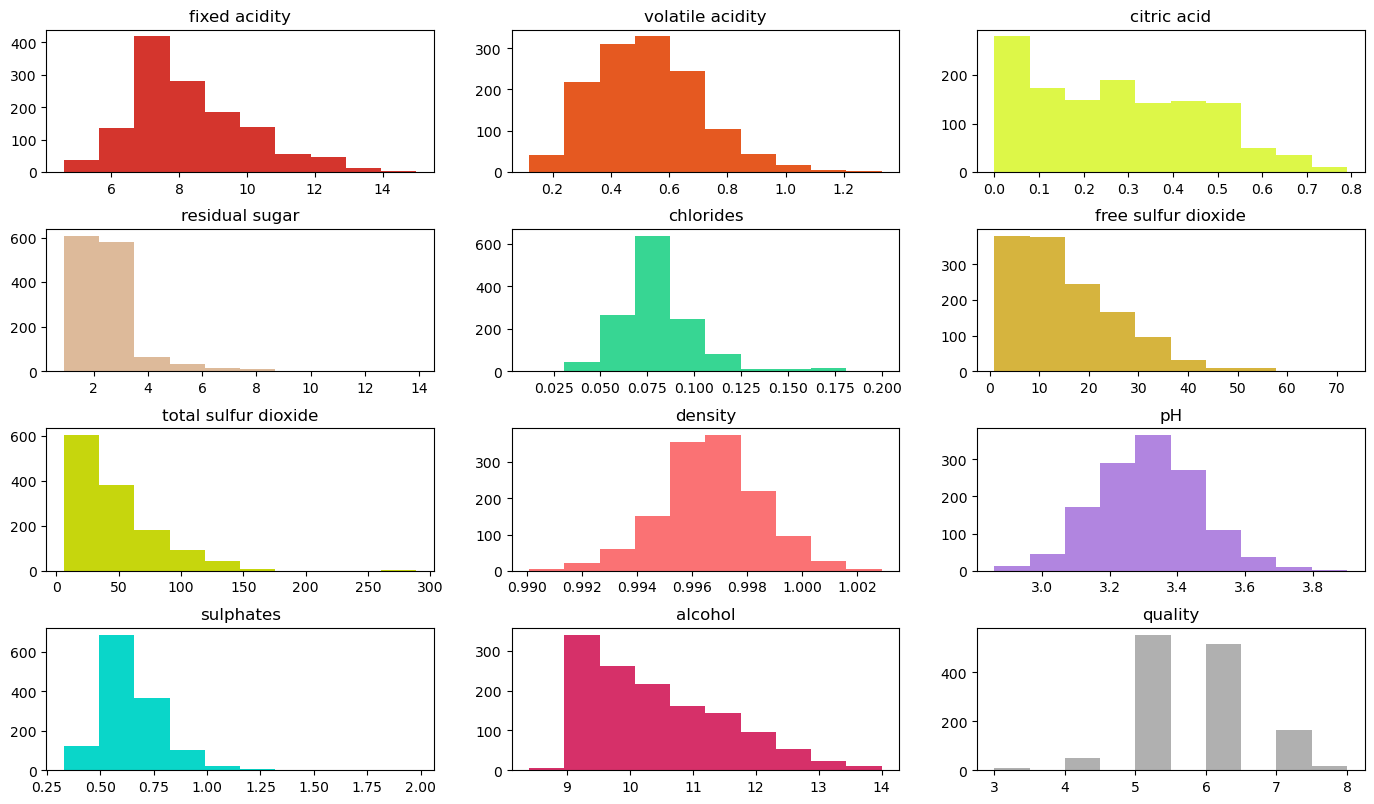

In [154]:
fig, ax = plt.subplots(4, 3, figsize=(14, 8))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for i, feature in enumerate(wine.columns[:12]):
    row = i // 3
    col = i % 3
    ax[row, col].hist(
        wine.loc[:, f"{feature}"], color=color_palette[f"{feature}"]
    )
    ax[row, col].set_title(f"{feature}")

#### Feature correlations
Since all of the values of feature correlations are below 0.8 we might assume multicollinearity is not present. </br>

**Strong** correlations are found between:
* fixed acidity and citric acid (0.67)
* fixed acidity and density  (0.67)
* fixed acidity and ph are *negatively correlated* (-0.69)
* total sulfur dioxide and free sulfur dioxide (0.67)

Some of the correlations above could be explained:
* Since citric acid is a part of fixed acidity of wine the correlation is justified here.
* The lower PH value the more acidic the substance is thus the negative correlation between PH value and fixed acidity is as expected.
* Total sulfur dioxide ($SO_2$) is an amount of free and bound forms of $SO_2$ thus the correlation is justified. </br> </br></br>



**Moderate** correlations are found between:
* citric acidity and volatile acidity (-0.55)
* citric acidity and ph (-0.55)
* alcohol and density (-0.5)
* alcohol and quality are *positively correlated*  (0.48)

**Quality** correlation with the following features stands out:
* Positive:
    * alcochol (0.49 - moderate)
    * sulphites (0.31 - weak)
    * citric acid (0.24 - weak)
* Negative:
    * volatile acidity (-0.39 - moderate)
    * density (-0.19 - very weak)
    * total sulfur dioxide (-0.18 - very weak)
    * chlorides (-0.19 -  very weak) 

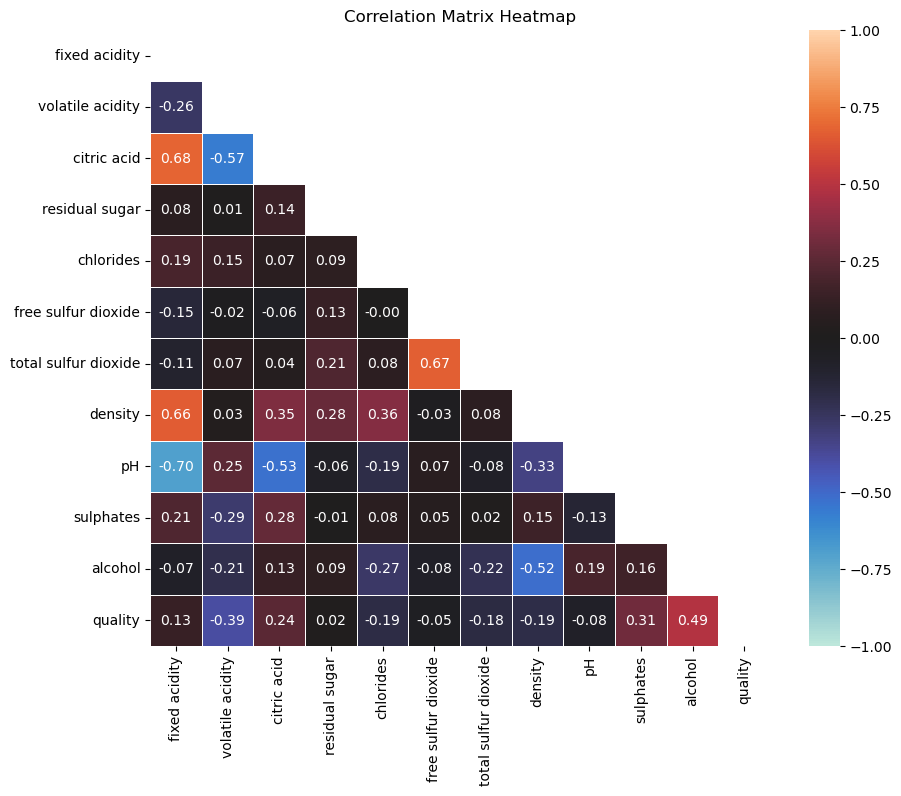

In [155]:
corr_matrix = wine.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix.iloc[:12, :12], dtype=bool))
sns.heatmap(
    corr_matrix.iloc[:12, :12],
    mask=mask,
    annot=True,
    cmap="icefire",
    vmin=-1,
    vmax=1,
    center=0,
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Matrix Heatmap");

#### Variance Inflation Factor (VIF)
The multicollinearity analysis using VIF has prompted that:
* Fixed acidity (VIF = 6.15) shows moderate to high multicollinearity, as it is above the typical threshold of 5.
* Density (VIF = 6.09) is close to the threshold, indicating moderate multicollinearity, likely with other variables like fixed acidity.

Due to this and the fact that Fixed acidity and Density are strongly correlated (0.67) the regression model should include only one of those features but not both of them. since density is more correlated with quality it will be investigated further instead of fixed acidity.

In [156]:
wine_transformed = wine.map(lambda x: 1/x if x != 0 else 0)
X = add_constant(wine_transformed)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [
    "{:.5f}".format(VIF(X.values, i)) for i in range(X.shape[1])
]
VIF = pd.DataFrame(vif_data)
VIF.iloc[1:, :]

,feature,VIF
1,fixed acidity,6.15123
2,volatile acidity,1.42592
3,citric acid,1.13313
4,residual sugar,1.69888
5,chlorides,1.30464
6,free sulfur dioxide,2.25118
7,total sulfur dioxide,2.46980
8,density,6.08672
9,pH,2.95600
10,sulphates,1.43236


### Feature relationship with quality

#### Mean distribution across quality levels

* **Alcohol** percentage is the most positively correlated with the quality and when looking at the mean values of each quality rating we see as well that the higher the quality the higher the alcohol level. In addition the good quality wine as much higher percentage of alcohol compared to poor quality wine. 
* **Citric acid** and **Sulphates** despite having weak positive correlation both exibit distinct increasing mean value for every quality rating.
</br>

</br>

* **Volatile acidity** is the most negatively correlated with quality and the trend remains for the mean Volatile acidity values for the quality rating. Here as well good and poor wine quality levels have a clear distinction.
* Both **Chlorides** and **Desnsity** are very weakly correlated however we see that from quality level 5 the means are distinctly lower for each increase in wine quality rating. Chlorides mean values for quality ratings however exhibit more clear distinction between good and poor quality wine than Density mean values.
* **Total sulfur dioxide** despite having the same correlation value as chlorides has different mean quality value pattern. Here we see a sharp spike for the quality level of 5. In addition good quality wine means are of similar values like the mean value of wine of quality 4. It might be difficult to draw insights regarding good and poor quality wine or overall influence on wine quality when considering only total sulfur dioxide thus we will look more into the 6 features mentioned above instead. 

Other features means for quality rating do not show a distinct pattern and the difference between good and poor quality wine is not that clearly evident.

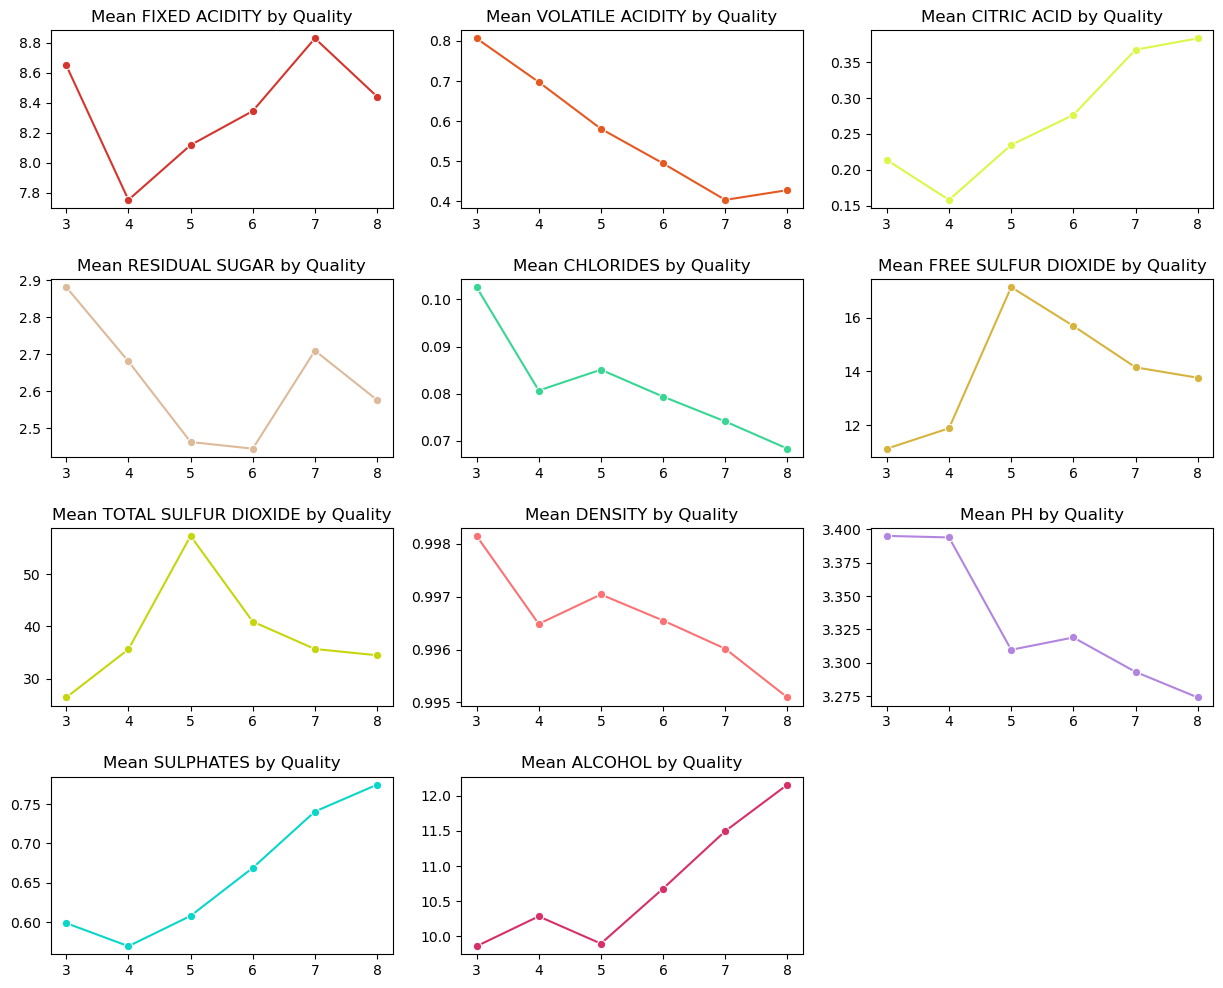

In [157]:
mean_features_by_quality = wine.groupby("quality").mean().reset_index()

plt.figure(figsize=(15, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for i, feature in enumerate(wine.columns[:11]):
    plt.subplot(4, 3, i + 1)
    sns.lineplot(
        data=mean_features_by_quality,
        x="quality",
        y=feature,
        marker="o",
        color=color_palette[f"{feature}"],
    )
    plt.title(f"Mean {feature.upper()} by Quality")
    plt.xlabel("")
    plt.ylabel("")

#### Value distributions across different quality values

If we were to look at the interquartile ranges (IQR) of the boxplots of the given features, alcohol and sulphites have much clearer distinction between quality ratings than citric acid. In addition both of them have higher maximum values for good quality wines than poor quality wines.

Volatile acidity IQR as well support the trend observed that the lower values of it are more common for the good quality wine. However density and clorides IQR do not exhibit such behavior which is as expected since they are very weakly negatively correlated.

Each plot as well demonstrated acceptable ranges of the wine properties. You may notice that Residual Sugar, Total Sulfur Dioxide, Free Sulfur Dioxide and Sulphates values are all mostly in lower half of the respected acceptable ranges. 

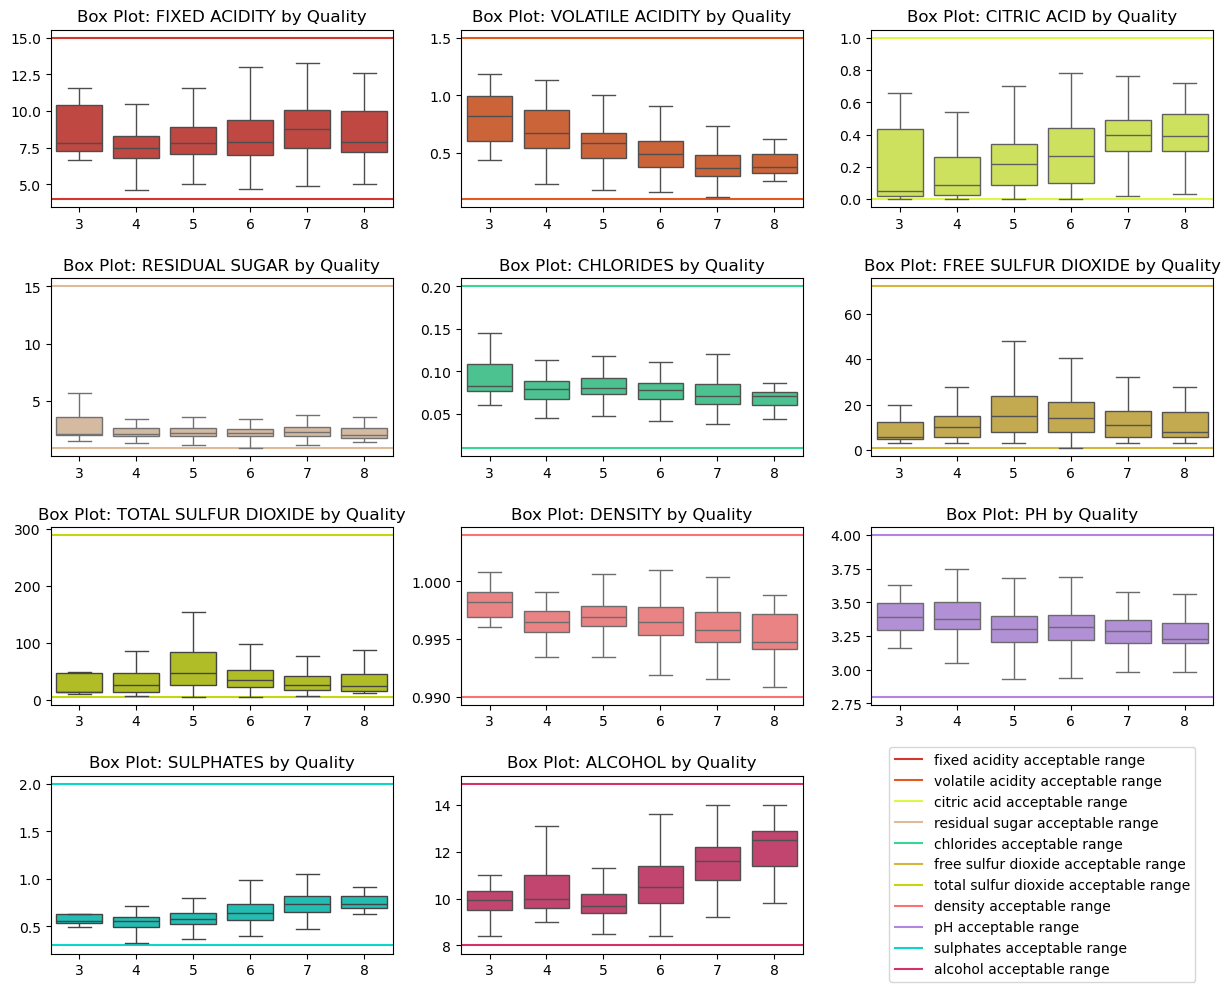

In [158]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
for i, feature in enumerate(wine.columns[:11]):
    plt.subplot(4, 3, i + 1)
    plt.axhline(
        y=wine_property_ranges[feature][0],
        color=color_palette[f"{feature}"],
        linestyle="-",
        label=f"{feature} acceptable range",
    )
    plt.axhline(
        y=wine_property_ranges[feature][1],
        color=color_palette[f"{feature}"],
        linestyle="-",
    )
    sns.boxplot(
        data=wine,
        x="quality",
        y=feature,
        showfliers=False,
        color=color_palette[f"{feature}"],
        legend=False,
    )
    plt.title(f"Box Plot: {feature.upper()} by Quality")
    plt.xlabel("")
    plt.ylabel("")

plt.subplot(4, 3, 12)
plt.axis("off")
handles = []
labels = []
for feature in wine.columns[:11]:
    handle = plt.Line2D(
        [0, 1], [0, 1], color=color_palette[f"{feature}"], linestyle="-"
    )
    handles.append(handle)
    labels.append(f"{feature} acceptable range")

plt.legend(handles, labels, loc="center", fontsize="medium", ncol=1);

##### Split the data

Her we putting 20% of data on a hold out. The remaing calculations will be done mainly on the 80% of the data which is 1087 records.

In [159]:
train_df, holdout_df = train_test_split(
    wine, test_size=0.2, stratify=wine["quality"], random_state=42
)
print(
    f"""The dataframe has been split to:
    Training data: {train_df.shape[0]} records
    Hold out data: {holdout_df.shape[0]} records"""
)

The dataframe has been split to:
    Training data: 1051 records
    Hold out data: 263 records


## 3. Goals

The objective is to determine if:
1. alcohol, citric acid and sulphates are in fact positively affecting wine quality
2. volatile acidity, density and chlorides are negatively affecting wine quality

These 2 objectives will be checked both in terms of the quality ratings and if they help differentiate good and poor quality wine.

To achieve the objectives set the following hypothesis needs to be proven to be true of false:
1. *Positive* influence on the wine quality:
    1. $H_0$: **alcohol** percentage of wine has NO impact on perceived wine quality</br>
       $H_A$: *alcohol* percentage of wine has a POSITIVE impact on perceived wine quality
    2. $H_0$: **citric acid** percentage of wine has NO impact on perceived wine quality</br>
       $H_A$: *citric acid* percentage of wine has a POSITIVE impact on perceived wine quality
    3. $H_0$: **sulphates** percentage of wine has NO impact on perceived wine quality</br>
       $H_A$: *sulphates* percentage of wine has a POSITIVE impact on perceived wine quality</br>
3. *Negative* influence on the wine quality:
    1. $H_0$: **volatile acidity** percentage of wine has NO impact on perceived wine quality</br>
       $H_A$: *volatile acidity* percentage of wine has a NEGATIVE impact on perceived wine quality
    2. $H_0$: **density percentage** of wine has NO impact on perceived wine quality</br>
       $H_A$: *denaisty percentage* of wine has a NEGATIVE impact on perceived wine quality
    3. $H_0$: **clorides percentage** of wine has NO impact on perceived wine quality</br>
       $H_A$: *clorides percentage* of wine has a NEGATIVE impact on perceived wine quality

## 4. Calculations

Each feature will go through the following calculations:
* Feature fit to a linear regression
* Check for linear regression assumptions of the model:
     1.  **Linear relationship** - Harvey-Collier Test: This test specifically checks for the presence of non-linearity in the relationship between the dependent and independent variables. If p-value greater than the significance level of 0.05 let us safely assume that the relationship between independent variables and the dependent variable is indeed linear.
     2.  **Heteroscedasticity** - Breusch-Pagan Test: If the p-value is below significance level of 0.05, it indicates that heteroscedasticity is present, meaning the variance of the errors is not constant.
     3.  **Independence of observations** - Durbin-Watson Test: Since the residuals should be independent of each other no autocorrelation should be found. A value close to 2 suggests that the residuals are not autocorrelated. Significant deviations from 2 indicate the presence of autocorrelation.
     4.  **Multivariate Normality** - Kolmogorov-Smirnov test: If the p-value greater than significance level of 0.05, there is no strong evidence to suggest that the residuals deviate significantly from a normal distribution
* The above mentioned linear model performance on holdout data
* Feature fit to a logistic regression
* Check for logistic regression assumptions
    1. **Independence of observations** - Durbin-Watson Test: Residuals should be independent and not autocorrelation in the logistic regression as well thus performing same test for logistic regression.
    2. **Perfect separation Test**:	Logistic regression assumes that there is no perfect separation of the data, meaning that the independent variables should not perfectly predict the outcome. If perfect separation is detected estimates can be unreliable. It is detected by looking if any coefficients are infinite.
    3.  **Linearity of Independent Variables and Logit** - Box-Tidwell Test: Since logistic regression assumes linearity of independent variables and logit(log odds) of the dependent variable unlike linear regression assumption of the dependent and independent variables to be related linearly, Box-Tidwell test is performed instead of Harvey-Collier test. If the p-value associated with the interaction term (X * log(X)) is less than significance level of 0.05, this suggests that the linearity assumption is violated.
* Summary of feature impact on quality will summarize the results of calculations done and state the grounds to either reject or confirm the $H_0$ hypothesis


### A. Possitive impact

### A.1 Alcohol

#### a. Alcohol: linear regression
The following information of the linear regression informs that:
* **Slope cooefficient is 0.3713** meaning alcohol percentage increase has a positive effect on the wine quality
* **Slope coeficient P>|t| (p-value) is higher than 0.05** meaning coeficient is statistically significantly different than 0 thus relationship between alcohol and quality is statistically significant.
* **The 95% confidence interval for the coefficient is [0.331, 0.412]** meaning true coefficient lies in a range which does not include 0 as well.
* **R-squared (R²) is 0.238** meaning that 23.8% of the variance in the quality is explained by the model which includes only alcohol. 

In [160]:
x_train_alco = train_df["alcohol"].values.reshape(-1, 1)
y_train_quality = train_df["quality"].values
x_train_alco_with_const = sm.add_constant(x_train_alco)
model_alco = sm.OLS(y_train_quality, x_train_alco_with_const)

results_alco = model_alco.fit()
print(results_alco.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     327.6
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           6.13e-64
Time:                        16:20:50   Log-Likelihood:                -1142.7
No. Observations:                1051   AIC:                             2289.
Df Residuals:                    1049   BIC:                             2299.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7555      0.215      8.154      0.0

#### b. Check for linear regression assumptions

Only 2 out of the 4 linear regression assumptions passes. </br>
Alcohol and quality does seem to form a linear relationship and the independence of observations is proven by autocorrelation not being present between residuals. </br>
However the variance of errors is not constant and residuals are not normally distributed.

In [161]:
df = check_linear_reg_assumptions(results_alco)
df

,Statistic,p-value,Result,Assumption passed
Tests,,,,
Harvey-Collier Test:,1.035870,0.343381,Relationship is linear,Pass
Breusch-Pagan Test: LM,18.863336,0.000014,Heteroscedasticity found,Fail
Breusch-Pagan Test: F,19.171530,0.000013,Heteroscedasticity found,Fail
Durbin-Watson Test:,2.013834,,Autocorrelation not found,Pass
Kolmogorov-Smirnov Test:,0.106107,0.0,Residuals are non-normally distributed,Fail


#### c. Alcohol: Linear model performance on holdout data
* **Mean Absolute Error (MAE):** average magnitude of errors between the predicted values and the actual values seems to be similar when using either training or test data. A slightly better score of holdout data suggest model is generalizing well and is not overfitting the training data
* **Mean Squared Error (MSE):** Lower MSE score on holdout data proves as well that model performs well on unseen data.
* **Root Mean Squared Error (RMSE):** Lower RMSE score on holdout data again proves that model performs well on unseen data.
* **R-squared (R²):** Surprisingly even better explanation (1.5% better) of quality variance is seen once the holdout data is being used.

Overall we may conclude that the linear regression model using alcohol performs very well on the unseen data, not overfitting the training data and generalizing well. The model is capable to explain 23.8% - 25.3% of quality valiance is quite good result as well.

In [162]:
df = test_holdout_model(
    "alcohol",
    results_alco,
    x_train_alco_with_const,
    y_train_quality,
    holdout_df,
)
df

,Training data,Holdout data
Mean Absolute Error (MAE),0.563384,0.555781
Mean Squared Error (MSE),0.515128,0.503629
Root Mean Squared Error (RMSE),0.717724,0.709668
R-squared (R²),0.238000,0.253706


#### d. Alcohol: Logistic regression
The logistic regression provides the following summary:
* **The x1 coefficient** is 1.096 suggesting that increasing alcohol percentage increases odds that wine will be classified as good quality
* **95% confidence interval** is [0.934, 1.258] which does not include 0 making the alcohol influence on quality statistically significant
* **Pseudo R-squ.:** The value of 0.1686 suggest that logistic regression explains 16.86% (moderate amount) of quality variance.
* **Log-Likelihood and LL-Null difference** value 122.46 suggests that model having alcohol predictor is significantly better at fitting the data than a model with no predictors.

In [163]:
y_train_quality_binary = train_df["quality_binary"].values
logit_model_alco = sm.Logit(y_train_quality_binary, x_train_alco_with_const)
Log_result_alco = logit_model_alco.fit()
print(Log_result_alco.summary());

Optimization terminated successfully.
         Current function value: 0.574595
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1049
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                  0.1686
Time:                        16:20:50   Log-Likelihood:                -603.90
converged:                       True   LL-Null:                       -726.36
Covariance Type:            nonrobust   LLR p-value:                 3.323e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.2062      0.851    -13.172      0.000     -12.874      -9.539
x1             1.0960      0.

#### e. Logistic regression assumptions
All logistic regression assumption passes. Observations are independent since autocorrelation is not found, perfect separation is not detected and the relationship between alcohol and logit of quality is linear. </br>


In [164]:
df = check_logistic_reg_assumptions(Log_result_alco, train_df, "alcohol")
df

Optimization terminated successfully.
         Current function value: 0.573315
         Iterations 7


,Statistic,p-value,Result,Assumption pass
Tests,,,,
Durbin-Watson Test:,2.030509,,Autocorrelation not found,Pass
Perfect separation Test:,,,Perfect separation NOT detected.,Pass
Box-Tidwell Test:,,0.088557,Relationship is linear,Pass


#### f. Summary of alcohol impact on quality

##### Summary:
* **Linear Regression:** Alcohol percentage has a **positive and statistically significant effect** on wine quality (coefficient = 0.3713, p-value < 0.05). The **model explains 23.8%** of the variance in quality, though some assumptions (constant variance and normality of residuals) are violated. Linear model as well performed well on unseen data thurther proving above stated insights.
* **Logistic Regression:** Higher **alcohol content increases the odds of wine being classified as good quality** (coefficient = 1.096, significant with 95% CI not including 0) thus it is significant predictor of whether a wine is classified as "good" or "poor". The model explains 16.86% of the variance in quality, and all assumptions are met.

##### Argument for Hypothesis Testing $H_0$:
Given the statistically significant results in both models (p-value < 0.05, confidence intervals excluding 0), we **reject the null hypothesis** $H_0$ that alcohol percentage has no impact on perceived wine quality **in favor of** $H_A$ which states that alcohol percentage of wine has a **POSITIVE impact on perceived wine quality**. Both linear and logistic regression indicate a meaningful relationship between alcohol content and wine quality.

### A.2 Sulphates

#### a. Sulphates: Linear regression
The following information of the linear regression informs that:
* **Slope cooefficient is 1.7829** meaning sulphates increase has a positive effect on the wine quality which is even stronger than alcohol
* **Slope coefficient P>|t| (p-value) is higher than 0.05** meaning coefficient is statistically significantly different than 0 thsu relationship between sulphates and quality is statistically significant.
* **The 95% confidence interval for the coefficient is [ 1.470, 2.096]** meaning true coefficient lies in a range which does not include 0 as well.
* **R-squared (R²) is 0.106** meaning that only 10.6% of the variance in the quality is explained by the model which includes only sulphates. This is 13.2% less than linear model containing alcohol explained. 

In [165]:
x_train_sulph = train_df["sulphates"].values.reshape(-1, 1)
y_train_quality = train_df["quality"].values
x_train_sulph_with_const = sm.add_constant(x_train_sulph)
model_sulph = sm.OLS(y_train_quality, x_train_sulph_with_const)

results_sulph = model_sulph.fit()
print(results_sulph.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     125.0
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.71e-27
Time:                        16:20:50   Log-Likelihood:                -1226.4
No. Observations:                1051   AIC:                             2457.
Df Residuals:                    1049   BIC:                             2467.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4748      0.106     42.122      0.0

#### b. Linear regression assumptions
Only 2 out of the 4 linear regression assumptions passes. Sulphates and quality does seem to form a linear relationship and no autocorrelation between residuals is found. However the variance of errors is not constant and residuals are not normally distributed.

In [166]:
df = check_linear_reg_assumptions(results_sulph)
df

,Statistic,p-value,Result,Assumption passed
Tests,,,,
Harvey-Collier Test:,1.042121,0.318424,Relationship is linear,Pass
Breusch-Pagan Test: LM,44.151250,0.0,Heteroscedasticity found,Fail
Breusch-Pagan Test: F,45.999622,0.0,Heteroscedasticity found,Fail
Durbin-Watson Test:,2.044773,,Autocorrelation not found,Pass
Kolmogorov-Smirnov Test:,0.101804,0.0,Residuals are non-normally distributed,Fail


#### c. Sulphates: Linear model performance on holdout data
* **Mean Absolute Error (MAE):** average magnitude of errors seems to be similar when using either training or test data. A slightly worse score of holdout data suggest model is generalizing quite well and is not overfitting the training data too much.
* **Mean Squared Error (MSE):** Slightly worse MSE score on holdout data proves as well that model performs well on unseen data.
* **Root Mean Squared Error (RMSE):** Slightly worse RMSE score on holdout data again proves that model performs well on unseen data.
* **R-squared (R²):** Unfortunately the explanation of quality variance using the holdout data is nearly 2 times worse having 4.7% less explanation than the training data.

Overall we may conclude that the linear regression model using sulphates performs consistently on the unseen data and training data, not overfitting the training data and generalizing well. Unfortunately the model is capable to expnain only 5.86% - 10.6% of the varinace of quality suggesting that sulphates property is not the one that could capture the underlying patterns in the data.

In [167]:
df = test_holdout_model(
    "sulphates",
    results_sulph,
    x_train_sulph_with_const,
    y_train_quality,
    holdout_df,
)
df

,Training data,Holdout data
Mean Absolute Error (MAE),0.634524,0.639411
Mean Squared Error (MSE),0.604048,0.635284
Root Mean Squared Error (RMSE),0.777205,0.797047
R-squared (R²),0.106466,0.058615


#### d. Suphates: Logistic regression
The logistic regression provides the following summary:
* **The x1 coefficient** is 4.8853 suggesting that increasing sulphates increases odds that wine will be classified as good quality
* **95% conffidence interval** is [3.813, 5.957] which does not include 0 making the sulphates influence on quality statistically significant
* **Pseudo R-squ.:** The value of 0.06866 suggest that logistic regression explains only 6.87% (small amount) of quality variance.
* **Log-Likelihood and LL-Null difference** value around 49.87 suggests that model having sulphates predictor is moderately better at fitting the data than a model with no predictors.

In [168]:
logit_model_sulph = sm.Logit(y_train_quality_binary, x_train_sulph_with_const)
Log_result_sulph = logit_model_sulph.fit()
print(Log_result_sulph.summary());

Optimization terminated successfully.
         Current function value: 0.643661
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1049
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                 0.06866
Time:                        16:20:50   Log-Likelihood:                -676.49
converged:                       True   LL-Null:                       -726.36
Covariance Type:            nonrobust   LLR p-value:                 1.733e-23
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9996      0.351     -8.549      0.000      -3.687      -2.312
x1             4.8853      0.

#### e. Logisic regression assumptions
Only 2 out of 3 logistic regression assumptions passes. Even though observations are independent since autocorrelation is not found as well as perfect separation is not detected, the relationship between sulphates and logit of quality is non-linear. </br>
This non-linear relationship means that the current model specification is not capturing the true relationship adequately.

In [169]:
df = check_logistic_reg_assumptions(Log_result_sulph, train_df, "sulphates")
df

Optimization terminated successfully.
         Current function value: 0.626220
         Iterations 6


,Statistic,p-value,Result,Assumption pass
Tests,,,,
Durbin-Watson Test:,2.053504,,Autocorrelation not found,Pass
Perfect separation Test:,,,Perfect separation NOT detected.,Pass
Box-Tidwell Test:,,0.0,Relationship is non-linear,Fail


#### f. Summary of sulphates impact on quality

##### Summary:
* **Linear Regression:**
The sulphates have a **positive and statistically significant effect on wine quality** (coefficient = 1.7829, p-value < 0.05), stronger than alcohol. The model **explains 10.6% of the variance in quality**, which is **lower than** the model for **alcohol**. However, only **two out of four regression assumptions are met**, with violations in constant variance and normality of residuals. Despite these issues, the model performs consistently on unseen data, suggesting it generalizes well, though it only explains 5.86% to 10.6% of the variance in quality, indicating that **sulphates alone are not a strong predictor**.

* **Logistic Regression:**
Increasing sulphates **significantly increases the odds of wine being classified as good quality** (coefficient = 4.8853, with a 95% CI of [3.813, 5.957]). However, the model explains only 6.87% of the variance in quality, indicating a **modest fit**. While most assumptions are met, the non-linear relationship between sulphates and the logit of quality suggests the **model may NOT adequately capture the true relationship**.

##### Argument for Hypothesis Testing:
Given the significant positive coefficients in both the linear and logistic regression models, we **reject the null hypothesis** that sulphates have no impact on perceived wine quality. However, the relatively low explanatory power and the non-linear relationship in the logistic regression suggest that while sulphates have a significant effect, **they may NOT be the best standalone predictor of wine quality**.

### A.3 Citric acid

#### a. Citric acid: Linear regression
The following information of the linear regression informs that:
* **Slope cooefficient is 0.9899** meaning citric acid increase has a possitive effect on the wine quality which is similar to sulphates
* **Slope coefficient P>|t| (p-value) is higher than 0.05** meaning coefficient is statistically significantly different than 0 thus relationship between citric acid and quality is statistically significant.
* **The 95% confidence interval for the coefficient is [0.735, 1.245]** meaning true coefficient lies in a range which does not include 0 as well.
* **R-squared (R²) is  0.053** meaning that only 5.3% of the variance in the quality is explained by the model which includes only citric acid. This is around  twice less than linear model containing sulphates explained. 

In [170]:
x_train_citra = train_df["citric acid"].values.reshape(-1, 1)
x_train_citra_with_const = sm.add_constant(x_train_citra)
model_citra = sm.OLS(y_train_quality, x_train_citra_with_const)

results_citra = model_citra.fit()
print(results_citra.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     58.15
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.44e-14
Time:                        16:20:50   Log-Likelihood:                -1257.2
No. Observations:                1051   AIC:                             2518.
Df Residuals:                    1049   BIC:                             2528.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3690      0.042    126.621      0.0

#### b. Linear regression assumptions
Only 1 out of the 4 linear regression assumptions fail which is the best result seen compared to alcohol and sulphates. </br>
Citric acid and quality does seem to form a linear relationship, no autocorrelation between residuals is found and the variance of errors is finally constant. </br>
Unfortunately the residuals are not normally distributed.

In [171]:
df = check_linear_reg_assumptions(results_citra)
df

,Statistic,p-value,Result,Assumption passed
Tests,,,,
Harvey-Collier Test:,1.047070,0.29933,Relationship is linear,Pass
Breusch-Pagan Test: LM,1.972056,0.16023,Heteroscedasticity not found,Pass
Breusch-Pagan Test: F,1.972003,0.160531,Heteroscedasticity not found,Pass
Durbin-Watson Test:,2.012848,,Autocorrelation not found,Pass
Kolmogorov-Smirnov Test:,0.145760,0.0,Residuals are non-normally distributed,Fail


#### c. Citric acid: Linear model performance on holdout data
* **Mean Absolute Error (MAE):** average magnitude of errors seems to be slightly better when using test data compared to training data. This suggests that model is generalizing quite well and is not overfitting the training data too much.
* **Mean Squared Error (MSE):** Slightly better MSE score on holdout data still suggests that model performs well on unseen data.
* **Root Mean Squared Error (RMSE):** Slightly better RMSE score on holdout data again proves that model performs well on unseen data.
* **R-squared (R²):** A better explanation (3.47% better) of quality variance is seen once the holdout data is being used.

Overall we may conclude that the linear regression model using citric acid performs consistently on the unseen data and training data. Unfortunately the model is capable to expnain only 5.25% - 8.72% of the varinace of quality suggesting that citric acid model capture the underlying patterns in the data which is similar to model uning sulphates.

In [172]:
df = test_holdout_model(
    "citric acid",
    results_citra,
    x_train_citra_with_const,
    y_train_quality,
    holdout_df,
)
df

,Training data,Holdout data
Mean Absolute Error (MAE),0.660604,0.654774
Mean Squared Error (MSE),0.640518,0.615984
Root Mean Squared Error (RMSE),0.800323,0.784847
R-squared (R²),0.052519,0.087214


#### d. Citric acid: Logistic regression
The logistic regression provides the following summary:
* **The x1 coefficient** is  2.0035 suggesting that increasing citric acid increases odds that wine will be clasified as good quality
* **95% conffidence interval** is [1.341, 2.666] which does not include 0 making the citric acid influence on quality statistically significant
* **Pseudo R-squ.:** The value of 0.02515 suggest that logistic regression explains only 2.52% (very small amount) of quality variance.
* **Log-Likelihood and LL-Null difference** value around 18.26 suggests that model having citric acid predictor does not provide a substantial improvement over the null model.

In [173]:
logit_model_citra = sm.Logit(y_train_quality_binary, x_train_citra_with_const)
Log_result_citra = logit_model_citra.fit()
print(Log_result_citra.summary());

Optimization terminated successfully.
         Current function value: 0.673736
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1049
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                 0.02515
Time:                        16:20:50   Log-Likelihood:                -708.10
converged:                       True   LL-Null:                       -726.36
Covariance Type:            nonrobust   LLR p-value:                 1.504e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3984      0.108     -3.694      0.000      -0.610      -0.187
x1             2.0035      0.

#### e. Logistic regression assumptions
Only 2 out of 3 logistic regression assumptions passes. Even though observations are independent since autocorrelation is not found as well as perfect separation is not detected, the relationship between citric acid and logit of quality is non-linear. </br>
This non-linear relationship means that the current model specification is not capturing the true relationship adequately.

In [174]:
df = check_logistic_reg_assumptions(Log_result_citra, train_df, "citric acid")
df

Optimization terminated successfully.
         Current function value: 0.670373
         Iterations 5


,Statistic,p-value,Result,Assumption pass
Tests,,,,
Durbin-Watson Test:,2.038623,,Autocorrelation not found,Pass
Perfect separation Test:,,,Perfect separation NOT detected.,Pass
Box-Tidwell Test:,,0.008363,Relationship is non-linear,Fail


#### f. Summary of citric acid impact on quality

##### Summary:
* **Linear Regression (Citric Acid):**
Citric acid has a **positive and statistically significant effect on wine quality** (coefficient = 0.9899, p-value < 0.05). The model explains **only 5.3% of the variance** in quality, which is **lower than the model for sulphates**. Most linear regression assumptions are met: the relationship is linear, no autocorrelation is found, and the variance of errors is constant. However, residuals are not normally distributed. The model performs **consistently on unseen data**, showing slightly better error metrics and **explaining up to 8.72%** of the variance in quality, though its **overall explanatory power is limited**.

* **Logistic Regression (Citric Acid):**
Increasing citric acid significantly **increases the odds of wine being classified as good quality** (coefficient = 2.0035, with a 95% CI of [1.341, 2.666]). However, the **model explains only 2.52%** of the variance in quality, suggesting **a weak fit**. The Log-Likelihood difference of 18.26 indicates that the model with citric acid as a predictor provides **only a modest improvement over the null model**. Most assumptions are met, but the non-linear relationship between citric acid and the logit of quality suggests **the model does not fully capture the true relationship**.

##### Argument for Hypothesis Testing:
Given the statistically significant coefficients in both models, we **reject the null hypothesis** that citric acid has no impact on perceived wine quality. However, the low explanatory power, particularly in the logistic regression, suggests that while citric acid has a significant effect, it is **not a strong predictor of wine quality on its own**.

### B. Negative impact

### B.1 Volatile acidity

#### a. Volatile acidity: Linear regression
The following information of the linear regression informs that:
* **Slope coefficient is -1.6881** meaning volatile acidity increase has a negative effect on the wine quality 
* **Slope coefficient P>|t| (p-value) is higher than 0.05** meaning coefficient is statistically significantly different than 0 thus relationship between volatile acidity and quality is statistically significant.
* **The 95% confidence interval for the coefficient is [-1.946, -1.430]** meaning true coefficient lies in a range which does not include 0 as well.
* **R-squared (R²) is 0.136** meaning that only 13.6% of the variance in the quality is explained by the model which includes only volatile acidity. 

In [175]:
x_train_vac = train_df["volatile acidity"].values.reshape(-1, 1)
x_train_vac_with_const = sm.add_constant(x_train_vac)
model_vac = sm.OLS(y_train_quality, x_train_vac_with_const)

results_vac = model_vac.fit()
print(results_vac.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     165.1
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.44e-35
Time:                        16:20:50   Log-Likelihood:                -1208.8
No. Observations:                1051   AIC:                             2422.
Df Residuals:                    1049   BIC:                             2431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5196      0.073     89.284      0.0

#### b. Linear regression assumptions
Like citric acid linear regressions, linear regression including volatile acidity has only 1 out of the 4 linear regression assumptions failing. </br>
Volatile acidity and quality does seem to form a linear relationship, observasions are independent since no autocorrelation between residuals is found and the variance of errors is constant. </br>
Unfortunatelly the residuals are non-normally distributed.

In [176]:
df = check_linear_reg_assumptions(results_vac)
df

,Statistic,p-value,Result,Assumption passed
Tests,,,,
Harvey-Collier Test:,1.079678,0.190182,Relationship is linear,Pass
Breusch-Pagan Test: LM,0.003733,0.951284,Heteroscedasticity not found,Pass
Breusch-Pagan Test: F,0.003725,0.951342,Heteroscedasticity not found,Pass
Durbin-Watson Test:,2.026197,,Autocorrelation not found,Pass
Kolmogorov-Smirnov Test:,0.061758,0.00063,Residuals are non-normally distributed,Fail


#### c. Volatile acidity: Linear model performance on holdout data
* **Mean Absolute Error (MAE):** MAE seems to be  slightly better when using test data compared to training data which suggest model is generalizing quite well.
* **Mean Squared Error (MSE):** Slightly lower MSE score on holdout data proves as well that model performs well on unseen data.
* **Root Mean Squared Error (RMSE):** Slightly lower RMSE score on holdout data again proves that model does not overfit training data.
* **R-squared (R²):** Unexpectedly better explanation (9% better) of quality variance is seen once the holdout data is being used.

Overall we may conclude that the linear regression model using sulphates performs consistently on the unseen data and training data, not overfitting the training data and generalizing well. Since the model is capable to expnain 13.6% - 22.7% of a portion of varinace of quality suggesting that volatile acidity is capturing well some of the underlying patterns in the data.

In [177]:
df = test_holdout_model(
    "volatile acidity",
    results_vac,
    x_train_vac_with_const,
    y_train_quality,
    holdout_df,
)
df

,Training data,Holdout data
Mean Absolute Error (MAE),0.611414,0.588455
Mean Squared Error (MSE),0.584114,0.521659
Root Mean Squared Error (RMSE),0.764274,0.722260
R-squared (R²),0.135953,0.226988


#### d. Volatile acidity: Logistic regression
The logistic regression provides the following summary:
* **The x1 coefficient** is  -4.0628 suggesting that increasing volatile acidity decreases odds that wine will be clasified as good quality
* **95% coeffidence interval** is [-4.863, -3.262] which does not include 0 making the voliatile acidity influence on quality statistically significant
* **Pseudo R-squ.:** The value of 0.08029 suggest that logistic regression explains only 8.03% (small amount) of quality variance.
* **Log-Likelihood and LL-Null difference** value around 58.32 suggests that model having volatile acidity predictor does a better job of explaining the variability in the data compared to a model with no predictors.

In [178]:
logit_model_vac = sm.Logit(y_train_quality_binary, x_train_vac_with_const)
Log_result_vac = logit_model_vac.fit()
print(Log_result_vac.summary());

Optimization terminated successfully.
         Current function value: 0.635626
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1049
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                 0.08029
Time:                        16:20:50   Log-Likelihood:                -668.04
converged:                       True   LL-Null:                       -726.36
Covariance Type:            nonrobust   LLR p-value:                 3.451e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2654      0.224     10.116      0.000       1.827       2.704
x1            -4.0628      0.

#### e. Logistic regression assumptions
Only 2 out of 3 logistic regression assumptions passes. Even though observations are independent since autocorrelation is not found as well as perfect separation is not detected, the relationship between volatile acidity and logit of quality is non-linear. </br>
This non-linear relationship means that the current model specification is not capturing the true relationship adequately.

In [179]:
df = check_logistic_reg_assumptions(
    Log_result_vac, train_df, "volatile acidity"
)
df

Optimization terminated successfully.
         Current function value: 0.632423
         Iterations 5


,Statistic,p-value,Result,Assumption pass
Tests,,,,
Durbin-Watson Test:,2.049398,,Autocorrelation not found,Pass
Perfect separation Test:,,,Perfect separation NOT detected.,Pass
Box-Tidwell Test:,,0.007725,Relationship is non-linear,Fail


#### f. Summary of Volatile acidity impact on quality

##### Summary:
* **Linear Regression:**
Volatile acidity has a **significant negative effect on wine quality** (coefficient = -1.6881, p-value < 0.05). The model **explains 13.6%** of the variance in quality. Most linear regression assumptions are met: the relationship is linear, there is no autocorrelation, and the variance of errors is constant. However, the residuals are not normally distributed. The model performs consistently **on unseen data**, showing slightly better error metrics and **explaining up to 22.7%** of the variance in quality. This suggests that volatile acidity **captures some underlying patterns in the data better than citric acid or sulphates**.

* **Logistic Regression:**
Increasing volatile acidity **significantly decreases the odds of wine being classified as good quality** (coefficient = -4.0628, with a 95% CI of [-4.863, -3.262]). The model **explains 8.03% of the variance in quality**, a **moderate fit** compared to other predictors. The Log-Likelihood difference of 58.32 indicates that the **model with volatile acidity** as a predictor **does a better job of explaining** the variability in the data than a model with no predictors. However, the non-linear relationship between volatile acidity and the logit of quality suggests that the model may **not fully capture the true relationship**.

##### Argument for Hypothesis Testing:
Given the significant negative coefficients in both models, we **reject the null hypothesis** that volatile acidity has no impact on perceived wine quality **in favor of the alternative hypothesis, which states that volatile acidity has a negative impact on perceived wine quality**. Both linear and logistic regression results indicate a **meaningful negative relationship** between volatile acidity and wine quality.

### B.2 Density

#### a. Density: Linear regression
The following information of the linear regression informs that:
* **Slope coefficient is -85.7028** meaning density increase has a very strong negative effect on the wine quality 
* **Slope coefficient P>|t| (p-value) is higher than 0.05** meaning coefficient is statistically significantly different than 0 thus relationship between density and quality is statistically significant.
* **The 95% confidence interval for the coefficient is [-111.931, -59.475]** meaning true coefficient lies in a range which does not include 0 as well.
* **R-squared (R²) is 0.038** meaning that only 3.8% of the variance in the quality is explained by the model which includes only density. This is 9.8% less than linear model containing volatile acidity.

In [180]:
x_train_den = train_df["density"].values.reshape(-1, 1)
x_train_den_with_const = sm.add_constant(x_train_den)
model_den = sm.OLS(y_train_quality, x_train_den_with_const)

results_den = model_den.fit()
print(results_den.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     41.11
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.17e-10
Time:                        16:20:50   Log-Likelihood:                -1265.4
No. Observations:                1051   AIC:                             2535.
Df Residuals:                    1049   BIC:                             2545.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         91.0470     13.322      6.835      0.0

#### b. Linear regression assumptions
The same situation as volatile acidity linear regression can be observed with density linear regression.</br>
Density and quality does seem to form a linear relationship, observasions are independent since no autocorrelation between residuals is found and the variance of errors is constant. </br>
Unfortunately the residuals are non-normally distributed.

In [181]:
df = check_linear_reg_assumptions(results_den)
df

,Statistic,p-value,Result,Assumption passed
Tests,,,,
Harvey-Collier Test:,1.070014,0.21936,Relationship is linear,Pass
Breusch-Pagan Test: LM,1.373145,0.241272,Heteroscedasticity not found,Pass
Breusch-Pagan Test: F,1.372325,0.241679,Heteroscedasticity not found,Pass
Durbin-Watson Test:,1.974271,,Autocorrelation not found,Pass
Kolmogorov-Smirnov Test:,0.133705,0.0,Residuals are non-normally distributed,Fail


#### c. Density: Linear model performance on holdout data

* **Mean Absolute Error (MAE):** MAE seems to be  very similar when using either training or test data which suggest model is generalizing quite well.
* **Mean Squared Error (MSE):** Very similar MSE score on holdout data proves as well that model performs well on unseen data.
* **Root Mean Squared Error (RMSE):** Nearly identical RMSE score on holdout data again proves that model does not overfit training data.
* **R-squared (R²):** Slightly better explanation (0.5% better) of quality variance is seen once the holdout data is being used.

Overall we may conclude that the linear regression model using sulphates performs consistently on the unseen data and training data, not overfitting the training data and generalizing well. Unfortunately the model is capable to expnain only 3.77% - 3.27% of varinace of quality suggesting that density is not capturing the underlying patterns in the data.

In [182]:
df = test_holdout_model(
    "density", results_den, x_train_den_with_const, y_train_quality, holdout_df
)
df

,Training data,Holdout data
Mean Absolute Error (MAE),0.668372,0.672135
Mean Squared Error (MSE),0.650527,0.652789
Root Mean Squared Error (RMSE),0.806552,0.807953
R-squared (R²),0.037713,0.032676


#### d. Density: Logistic regression
The logistic regression provides the following summary:
* **The x1 coefficient** is -192.359 suggesting that increasing density very signifivantly decreases odds that wine will be classified as good quality
* **95% confidence interval** is [-260.993, -123.725] which does not include 0 making the densityy influence on quality statistically significant
* **Pseudo R-squ.:** The value of 0.0219 suggest that logistic regression explains only 2.19% (extremely small amount) of quality variance.
* **Log-Likelihood and LL-Null difference** value around 15.91 suggests that model having density predictor does not provide a substantial improvement over the null model.

In [183]:
logit_model_den = sm.Logit(y_train_quality_binary, x_train_den_with_const)
Log_result_den = logit_model_den.fit()
print(Log_result_den.summary());

Optimization terminated successfully.
         Current function value: 0.675980
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1049
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                 0.02190
Time:                        16:20:50   Log-Likelihood:                -710.45
converged:                       True   LL-Null:                       -726.36
Covariance Type:            nonrobust   LLR p-value:                 1.699e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.8455     34.902      5.497      0.000     123.439     260.252
x1          -192.3590     35.

#### e. Logistic regression assumptions
All logistic regression assumption passes. Observations are independent since autocorrelation is not found, perfect separation is not detected and the relationship between density and logit of quality is linear.

In [184]:
df = check_logistic_reg_assumptions(Log_result_den, train_df, "density")
df

         Current function value: 0.682096
         Iterations: 35


C:\Users\godak\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Statistic,p-value,Result,Assumption pass
Tests,,,,
Durbin-Watson Test:,2.024279,,Autocorrelation not found,Pass
Perfect separation Test:,,,Perfect separation NOT detected.,Pass
Box-Tidwell Test:,,0.265328,Relationship is linear,Pass


#### f. Summary of Density impact on quality

##### Summary:
* **Linear Regression:**
Density has a **significant and strong negative effect on wine quality** (coefficient = -85.7028, p-value < 0.05). The model explains **only 3.8%** of the variance in quality, which is **notably less than the model with volatile acidity**. Despite meeting most assumptions—linear relationship, no autocorrelation, and constant variance of errors—the residuals are not normally distributed. The model performs **consistently on unseen data**, with very similar error metrics across training and test data. However, it explains only 3.27% to 3.77% of the variance in quality, indicating that density **does NOT capture the underlying patterns in the data effectively**.

* **Logistic Regression:**
Increasing **density significantly decreases the odds of wine being classified as good quality** (coefficient = -192.359, with a 95% CI of [-260.993, -123.725]). The model explains a **very small amount of the variance** in quality (Pseudo R-squared = 2.19%). The Log-Likelihood difference of 15.91 suggests that the model with density as a predictor provides **only a minimal improvement over a null model**. However, all logistic regression assumptions are met, including the linearity of the relationship between density and the logit of quality.

##### Argument for Hypothesis Testing:
Given the significant negative coefficients in both linear and logistic regression models, we **reject the null hypothesis** that density has no impact on perceived wine quality **in favor of the alternative hypothesis, which states that density has a negative impact on perceived wine quality**. Both models indicate a meaningful, **though limited**, negative relationship between density and wine quality.

### B.3 Chlorides

#### a. Chlorides: Linear regression
The following information of the linear regression informs that:
* **Slope coefficient is -7.6860** meaning chlorides increase has a negative effect on the wine quality 
* **Slope coefficient P>|t| (p-value) is higher than 0.05** meaning coefficient is statistically significantly different than 0 thus relationship between chlorides and quality is statistically significant.
* **The 95% confidence interval for the coefficient is [-10.008, -5.364]** meaning true coeficient lies in a range which does not include 0 as well.
* **R-squared (R²) is 0.039** meaning that only 3.9% of the variance in the quality is explained by the model which includes only chlorides. This is 0.1% more than linear model containing density however the density slope coefficient is 78 points smaller which makes density negatve influence on quality much more noticible than chlorides.

In [185]:
x_train_clo = train_df["chlorides"].values.reshape(-1, 1)
x_train_clo_with_const = sm.add_constant(x_train_clo)
model_clo = sm.OLS(y_train_quality, x_train_clo_with_const)

results_clo = model_clo.fit()
print(results_clo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     42.18
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.28e-10
Time:                        16:20:50   Log-Likelihood:                -1264.8
No. Observations:                1051   AIC:                             2534.
Df Residuals:                    1049   BIC:                             2544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2542      0.099     63.164      0.0

#### b. Linear regression assumptions
Unfortunately chlorides linear regression model stands out from the models proving negative effect on quality. Once again 2 out of 4 assumptions fail. </br>
Clorides and quality does seem to form a linear relationship and no autocorrelation between residuals is found. However the variance of errors is not constant and residuals are not normally distributed.

In [186]:
df = check_linear_reg_assumptions(results_clo)
df

,Statistic,p-value,Result,Assumption passed
Tests,,,,
Harvey-Collier Test:,1.097547,0.143439,Relationship is linear,Pass
Breusch-Pagan Test: LM,3.896740,0.04838,Heteroscedasticity found,Fail
Breusch-Pagan Test: F,3.903799,0.048439,Heteroscedasticity found,Fail
Durbin-Watson Test:,1.974592,,Autocorrelation not found,Pass
Kolmogorov-Smirnov Test:,0.133006,0.0,Residuals are non-normally distributed,Fail


#### c. Chlorides: Linear model performance on holdout data
* **Mean Absolute Error (MAE):** MAE seems to be  very similar when using either training or test data which suggest model is generalizing quite well.
* **Mean Squared Error (MSE):** Slightly worse MSE score on holdout data proves as well that model performs well on unseen data.
* **Root Mean Squared Error (RMSE):** Nearly identical RMSE score on holdout data again proves that model does not overfit training data.
* **R-squared (R²):** Nearly twice worse explanation of quality variance is seen once the holdout data is being used.

Overall we may conclude that the linear regression model using sulphates performs consistently on the unseen data and training data, not overfitting the training data and generalizing well. Unfortunately the model is capable to expnain only 1.84% - 3.87% of varinace of quality suggesting that chlorides is not capturing the underlying patterns in the data.

In [187]:
df = test_holdout_model(
    "chlorides",
    results_clo,
    x_train_clo_with_const,
    y_train_quality,
    holdout_df,
)
df

,Training data,Holdout data
Mean Absolute Error (MAE),0.666199,0.675135
Mean Squared Error (MSE),0.649889,0.662413
Root Mean Squared Error (RMSE),0.806157,0.813887
R-squared (R²),0.038656,0.018415


#### d. Chlorides: Logistic regression
The logistic regression provides the following summary:
* **The x1 coefficient** is -18.6429 suggesting that increasing clorides decreases odds that wine will be classified as good quality
* **95% confidence interval** is [-25.172, -12.114] which does not include 0 making the chlorides influence on quality statistically significant
* **Pseudo R-squ.:** The value of 0.02443 suggest that logistic regression explains only 2.44% (extremely small amount) of quality variance.
* **Log-Likelihood and LL-Null difference** value around 17.75 suggests that model having chlorides predictor does not provide a substantial improvement over the null model.

In [188]:
logit_model_clo = sm.Logit(y_train_quality_binary, x_train_clo_with_const)
Log_result_clo = logit_model_clo.fit()
print(Log_result_clo.summary());

Optimization terminated successfully.
         Current function value: 0.674227
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1051
Model:                          Logit   Df Residuals:                     1049
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Sep 2024   Pseudo R-squ.:                 0.02443
Time:                        16:20:50   Log-Likelihood:                -708.61
converged:                       True   LL-Null:                       -726.36
Covariance Type:            nonrobust   LLR p-value:                 2.557e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6348      0.275      5.940      0.000       1.095       2.174
x1           -18.6429      3.

#### e. Logistic regression assumptions
Only 2 out of 3 logistic regression assumptions passes. Even though observations are independent since autocorrelation is not found as well as perfect separation is not detected, the relationship between chlorides and logit of quality is non-linear.
This non-linear relationship means that the current model specification is not capturing the true relationship adequately.

In [189]:
df = check_logistic_reg_assumptions(Log_result_clo, train_df, "chlorides")
df

Optimization terminated successfully.
         Current function value: 0.668880
         Iterations 5


,Statistic,p-value,Result,Assumption pass
Tests,,,,
Durbin-Watson Test:,2.032617,,Autocorrelation not found,Pass
Perfect separation Test:,,,Perfect separation NOT detected.,Pass
Box-Tidwell Test:,,0.000757,Relationship is non-linear,Fail


#### f. Summary of clorides impact on quality

##### Summary:
* **Linear Regression (Chlorides)**:
Chlorides have a **significant negative effect on wine quality** (coefficient = -7.6860, p-value < 0.05). The model explains **only 3.9%** of the variance in quality, which is **slightly more than the model with density but much less impactful** due to the smaller slope coefficient. Despite forming a linear relationship and having no autocorrelation, the model fails two key assumptions: the variance of errors is not constant, and residuals are not normally distributed. The model performs **consistently on unseen data**, with similar error metrics across training and test data. However, it only explains 1.84% to 3.87% of the variance in quality, indicating that **chlorides do NOT capture the underlying patterns in the data effectively**.

* **Logistic Regression (Chlorides)**:
Increasing chlorides **significantly decreases the odds of wine being classified as good quality** (coefficient = -18.6429, with a 95% CI of [-25.172, -12.114]). The model **explains a very small amount of the variance** in quality (Pseudo R-squared = 2.44%). The Log-Likelihood difference of 17.75 suggests that the model with chlorides as a predictor **does NOT provide a substantial improvement over a null model**. Additionally, the logistic regression model fails one assumption: the **relationship** between chlorides and the logit of quality is **non-linear**, indicating that the current model specification **does NOT capture the true relationship adequately**.

##### Argument for Hypothesis Testing:
Given the significant negative coefficients in both linear and logistic regression models, we **reject the null hypothesis** that chlorides have no impact on perceived wine quality **in favor of the alternative hypothesis**, which states that **chlorides have a negative impact on perceived wine quality**. Despite the low explanatory power, both models indicate a statistically significant negative relationship between chlorides and wine quality.

## 5. Conclusions of analysis

#### Feature Selection and Exclusion:
* The analysis concentrated on features that consistently demonstrated a meaningful relationship with wine quality. Total sulfur dioxide, despite its initial consideration due to its correlation of -0.18, was excluded from the final models due to its inconsistent pattern across different quality levels. Other features were excluded due to extremely weak correlation and/or unclear pattern of mean values per quality ratio. The focus was instead placed on alcohol, volatile acidity, sulphates, citric acid, density, and chlorides, as these features provided more reliable and interpretable insights into the factors affecting wine quality.

#### Positive Impact on Quality:
1. Alcohol Content
    - **Correlation**: Alcohol content exhibits a moderate positive correlation of 0.49 with wine quality.
    - **Linear Model Insights**: It explains approximately 24% of the variance in wine quality, making it a strong predictor.
    - **Logistic Model Insights**: Alcohol content significantly increases the odds of a wine being classified as good quality.
    - **Assumptions Failed**:
      - **Linear Regression**: Failed 2 out of 4 assumptions (Normality of residuals and Heteroscedasticity).
      - **Logistic Regression**: Passed all 3 assumptions.
    - **Conclusion**: Alcohol content is the most reliable predictor of wine quality, with a significant positive impact. Despite some assumption violations in the linear model, its overall influence remains strong.

2. Sulphates
    - **Correlation**: Sulphates have a weak positive correlation of 0.31 with wine quality.
    - **Linear Model Insights**: Accounts for 10.6% of the variance in quality.
    - **Logistic Model Insights**: Shows a positive impact on quality, though the effect is modest.
    - **Assumptions Failed**:
      - **Linear Regression**: Failed 2 out of 4 assumptions (Normality of residuals and Heteroscedasticity).
        - **Logistic Regression**: Failed 1 out of 3 assumptions (Non-linearity with quality logit).
      - **Conclusion**: Sulphates have a modest impact on wine quality but are limited by assumption violations in both models. They are a weaker predictor compared to alcohol.

3. Citric Acid
    - **Correlation**: Citric acid shows a weak positive correlation of 0.24 with wine quality.
    - **Linear Model Insights**: Explains about 5.3% of the variance in quality.
    - **Logistic Model Insights**: Has a positive effect on the likelihood of good quality classification.
    - **Assumptions Failed**:
        - **Linear Regression**: Failed 1 out of 4 assumptions (Normality of residuals).
        - **Logistic Regression**: Failed 1 out of 3 assumptions (Non-linearity with quality logit)
    - **Conclusion**: Citric acid has a weaker influence on wine quality. Its impact is less pronounced, but it still contributes positively.

#### Negative Impact on Quality:
4. Volatile Acidity
    - **Correlation**: Volatile acidity has a moderate negative correlation of -0.39 with wine quality.
    - **Linear Model Insights**: Explains 13.6% of the variance, indicating a significant negative impact.
    - **Logistic Model Insights**: Significantly decreases the odds of a wine being classified as good quality.
    - **Assumptions Failed**:
          - **Linear Regression**: Failed 1 out of 4 assumptions (Normality of residuals).
          - **Logistic Regression**: Failed 1 out of 3 assumptions (Non-linearity with quality logit)
      - **Conclusion**: Volatile acidity is a strong predictor with a notable negative impact on quality. It effectively distinguishes between good and poor quality wines despite some assumption issues in the linear model.
5. Density
    - **Correlation**: Density shows a very weak negative correlation of -0.19 with wine quality.
    - **Linear Model Insights**: Explains only 3.8% of the variance in quality.
    - **Logistic Model Insights**: Confirms a very weak negative effect on quality.
    - **Assumptions Failed**:
        - **Linear Regression**: Failed 1 out of 4 assumptions (Normality of residuals).
        - **Logistic Regression**: Passed all 3 assumptions.
    - **Conclusion**: Density is a weak predictor of wine quality, with minimal impact and weak correlation.
6. Chlorides
    - **Correlation**: Chlorides have a very weak negative correlation of -0.19 with wine quality.
    - **Linear Model Insights**: Accounts for 3.9% of the variance, indicating a minor negative impact.
    - **Logistic Model Insights**: Shows a weak negative effect on quality.
    - **Assumptions Failed**:
        - **Linear Regression**:Failed 2 out of 4 assumptions (Normality of residuals and Heteroscedasticity).
        - **Logistic Regression**: Failed 1 out of 3 assumptions (Non-linearity with quality logit).
    - **Conclusion**: Chlorides have a minor role in predicting wine quality. Its weak correlation and limited explanatory power make it less useful compared to other features.

 

#### Final Insights
Alcohol content emerges as the strongest predictor of wine quality with a clear positive impact, whereas volatile acidity is the main negative influence. Sulphates and citric acid show some correlation with quality but are less reliable due to violations of key model assumptions, including issues with residual normality and non-linearity. Density and chlorides have minimal relevance due to variance of quality being covered at around 4%. The findings highlight the importance of alcohol and volatile acidity in understanding wine quality while it must be acknowledged that the assumption have been violated as well. In addition since sample ratio mismatch was detected between "good" and "poor" quality of wines, insights from logistic regression should be taken with caution.

## 6. Suggestions for improvement

Here are a few suggestions of further actions to improve analysis:
* Investigate why Heteroscedasticity is detected in all of the linear regression models. In addition investigate what changes could be done to mitigate this issue.
* Investigate and solve residual non-normal distribution since is the common regression assumption which faied across all models. 
* Include more wine data to not have sample ratio mismatch between good and poor quality wine.
* Include a bigger variety of wines with quality other than 3, 4, 5, 6, 7 or 8.  